## Lateralus - Tool

### Summary Analysis
This is the code that analyzes segments of the song Lateralus - tool. 
Here it breaks the song into segments by the predominant downbeats (using essentia) and then clusters these segments together to pick out the important clusters. These important clusters are then used to create a summarization of the song.

### Goal 
To summarize the 9:24 minute song into smaller sections by a parameter.

In [5]:
%matplotlib inline
import os
import sys
import numpy as np
import essentia.standard as es
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

currentPath = os.getcwd()
inputPath = os.path.join(currentPath,'song/')
outputPath = os.path.join(currentPath,'song/summary/')

In [10]:
# Parameters Setting.  Change these to get different Summaries.
segmentLength = 16
nClusters = 10

In [15]:
for file in os.listdir(inputPath):
    if file.endswith(".mp3"):
    
        filename = file.split(".")[0]
        
        # Initializing algorithms from essentia
        loader = es.MonoLoader(filename = os.path.join(inputPath,file))
        writer = es.MonoWriter(filename = os.path.join(outputPath,filename + "_summary.mp3"), format="mp3")
        beatFinder = es.BeatTrackerMultiFeature()
        spectrum = es.Spectrum()
        window = es.Windowing(type = 'hann')
        mfcc = es.MFCC()
        
        samplingRate = 44100
        
        #Reading a wav file
        x = loader()
        beat = beatFinder(x)
        
        #Identifying segment positions 
        beatSegment = beat[0][segmentLength-1::segmentLength] 
        
        length = beatSegment.size
        lengthTime = x.size * 1/samplingRate
        startTime =  beatSegment[0:length-1]
        startTime = np.insert(startTime, 0, 0)
        endTime = beatSegment[0:length]
        
        #Slicing audio into segments
        slicer = es.Slicer(startTimes=startTime.tolist(), endTimes=endTime.tolist())
        frames = slicer(x)
        
        mfcc_means = []
        for f in frames[:]:
            frame = np.array(f,dtype="single")
            if frame.size % 2 != 0:
                frame = frame[:-1]
            mfcc_bands, mfcc_coeff = mfcc(spectrum(window(np.array(frame))))
            mfcc_means.append(np.mean(mfcc_coeff))
        
        # Building K means clusters on MFCC means
        #print "building clusters for", filename
        
        mfcc_feature = np.array(mfcc_means).reshape(-1,1)
        model = KMeans(n_clusters = nClusters, random_state=0)
        km = model.fit(mfcc_feature)
        closest, _ = pairwise_distances_argmin_min(km.cluster_centers_, mfcc_feature)
        
        # Writing the audio segments as files
        #print "writing segments for", filename
        audioSegment = []
        for i in range (0,nClusters):
            audioSegment = np.append(audioSegment, np.array(frames[closest[i]]))
        writer(audioSegment.astype("single"))
        print "Done Creating Summary for", filename
print "----------------Finished-----------------"

Done Creating Summary for Lateralus
----------------Finished-----------------


### Analysis

Here with the parameters segmentLength and nClusters I am able to summarize the important parts of the song.


### Method
This was done by the following method.

* Essentia was used to load and identify down beat locations in the mp3 version of the song. Then the song was chopped into segments of length (segmentLength) according to the beats.
* From each segment I extracted the mfcc and mfcc mean and clusters were created using these low level descriptors
* From nClusters, a representative segment was chosen and put together to create the summary song.
* This gave us the resulting Lateralus_summary file, shown below.

In [19]:
import IPython
summaryFile = os.path.join(outputPath,"Lateralus_summary.mp3")
IPython.display.Audio(summaryFile)

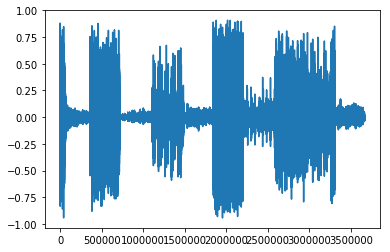

In [31]:

x = loader()

from pylab import plot, show
plot(x)
show() 
# Displays the summarized segments

## Results
The summary shows a successful representation of the song with all th elements from chorus, bridge and the different time signatures included in a 1:23 minute version of the song. Other summaries can be obtained by running the code using different parameters on the song. The same sort of analysis can be done for other music as well, which have recurring repetitive sections that can be summarized.